In [1]:
#imports

#general
import numpy as np
import pandas as pd

#visualization
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap


#ML
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn import  metrics
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
import shap
from sklearn.preprocessing import MinMaxScaler
import lime
import lime.lime_tabular

shap.initjs()


In [2]:
#load files
my_dir = r"data/"
out_dir = r"prediction_results/"
#genes to predict
new_genes = pd.read_csv(my_dir+"classifier_464_genes.csv", header = None)
new_genes = list(new_genes[0].values)
print(len(new_genes))

#known HRR genes
gold_standard = pd.read_csv(my_dir+"HRR_gold_standard_genes_and_modules.csv")

gs_genes = list(gold_standard["Gene"].values)
print(len(gs_genes))
gold_module = dict(zip(gold_standard["Gene"], gold_standard["Functional module"]))

short_name = {"DSB recognition":'Sensing', "End resection":'Resection', "Fanconi anemia pathway":'Fanconi',
              "Regulation (DNA damage response)":'DDR' ,"Strand invasion & D-loop formation":'D-Loop',
              "Synthesis and Holiday junctions processing":'Synthesis'}

new_genes = [gene for gene in new_genes if gene not in gs_genes]
print(len(new_genes))



464
78
388


In [3]:
#Summarize protein-protein interaction data: maximal value per gene per module
def load_ppi():
    string_fields =  pd.read_csv(my_dir+"string_fields.csv")
    string_fields.set_index("Unnamed: 0", inplace = True)
    def maximal_ppi(gs_genes):
        in_data = [gene + ".STRING.experimental" for gene in gs_genes if gene + ".STRING.experimental" in string_fields.columns]
        res = np.max(string_fields[in_data], axis = 1)
        return res
    ppi = pd.DataFrame(index = string_fields.index)
    for group_name in gold_standard.groupby("Functional module").groups:
        group = gold_standard.groupby("Functional module").get_group(group_name)["Gene"].to_list()
        ppi["PPI with "+short_name[group_name]] = maximal_ppi(group)
    return ppi

ppi = load_ppi()

In [4]:
def load_screens():
    extra_fields =  pd.read_csv(my_dir+"S4_classifier_extra_fields.csv")
    # there are no screen columns with "SPO11" so it's the same file as before
    extra_fields.drop(['NPP.clade.optimized.MRS',
           'HPA.tissue.coexpression.MRS'], axis = 1, inplace = True)
    extra_fields.set_index("Unnamed: 0", inplace = True)
    return extra_fields

screens = load_screens()

In [5]:
def load_mrs(genes):
    res = pd.DataFrame(index = genes)
    prefix = ["MRS/CladePP_", "MRS/HPA_coexpression_"]
    suffix = ".csv"
    interesting_col = "Score"
    col_name = [ "CladePP with ","Coexpression with " ]
    for group in short_name.values():
        for i in range(len(prefix)):
            mrs_table = pd.read_csv(my_dir + prefix[i] + group + suffix)
            # print(my_dir + prefix[i] + group + suffix)
            # print(mrs_table.head() )
            mrs_table.set_index("Gene", inplace = True)
            mrs_table = mrs_table[[interesting_col]]
            mrs_table.rename(columns = {interesting_col:col_name[i]+group}, inplace = True)
            # print(mrs_table.head() )
            res = pd.merge(res, mrs_table, left_index = True, right_index = True)
    return res

mrs = load_mrs(ppi.index)

In [6]:
raw_data = pd.merge(ppi, screens, left_index = True, right_index = True)
raw_data = pd.merge(raw_data, mrs, left_index = True, right_index = True)
print("ppi rows: " + str(ppi.shape[0]) + " screens rows: " + str(screens.shape[0]) + " mrs rows: " + str(mrs.shape[0]))


ppi rows: 19493 screens rows: 19520 mrs rows: 17609


In [7]:
missing_classifier_genes = [gene for gene in new_genes if gene not in raw_data.index]
print(missing_classifier_genes)
missing_gs_genes = [gene for gene in gs_genes if gene not in raw_data.index]
print(missing_gs_genes)

new_genes = [gene for gene in new_genes if gene in raw_data.index] #filter out genes for which we don't have data
print(len(new_genes))
raw_data.to_csv(my_dir + "raw_data.csv")
gs_genes = [gene for gene in gs_genes if gene in raw_data.index] #filter out genes for which we don't have data
print(len(gs_genes))


['RFC4', 'CHD3', 'UHRF1']
['FAAP100', 'FAAP20', 'FAAP24']
385
75


In [8]:

class ModuleClassifier:
    """
    A class used to represent a multiclass classifier

    ...

    Attributes
    ----------
    X : np array
    each row represents one training data sample, each col is a feature
    y : 1d array
    module labels for training data. Don't need to be encoded
    model_type : sklearn model
    Has to implement fit, predict and predict_proba
    scaler : sklearn.preprocessing
    How to scale data

    Methods
    -------
    label_encoding: transform labels ("A", "B" --> 0, 1)
    k_fold: split training data
    leave_one_out: preform cross-validation
    plot_confusion_matrix: for multiclass, plot confusion for training data
    test_model: get model accuracy
    train_model: train on all available data
    predict: get class prediction
    predict_proba: probabilities for each class
    """
    def __init__(self, X, y, model_type, scaler = False):
        self.X = X
        self.y = y
        self.y_encoded = self.label_encoding()
        self.model_type = model_type
        self.scaler = scaler

    def label_encoding(self):
        le = preprocessing.LabelEncoder()
        le.fit(self.y)
        self.encoder = le
        self.classes = le.classes_
        return le.transform(self.y)

    def k_fold(self, n_folds=3):
        #K-fold train-test split
        kf = KFold(n_splits=n_folds)
        return kf.split(self.X, self.y)

    def leave_one_out(self):
        k_fold = self.k_fold(self.X.shape[0])
        accuracy = 0
        expected = []
        predicted = []
        for train_index, test_index in k_fold:
            X_train, X_test = self.X.iloc[train_index], self.X.iloc[test_index]
            y_train, y_test = self.y_encoded[train_index], self.y_encoded[test_index]
            model = self.model_type
            if self.scaler:
                X_train = pd.DataFrame(self.scaler.fit_transform(X_train), columns = X_train.columns, index = X_train.index)
                X_test = pd.DataFrame(self.scaler.transform(X_test).reshape(1,-1), columns = X_test.columns, index = X_test.index)
            model.fit(X_train, y_train)
            # make predictions
            expected_y = y_test
            predicted_y = model.predict(X_test)
            accuracy += predicted_y == expected_y
            expected.extend(list(expected_y))
            predicted.extend(list(predicted_y))
        print ("Model got %d right out of %d, making it %.2f percent correct" %(accuracy, self.X.shape[0],
               accuracy*100/self.X.shape[0]))
        y_predicted=self.encoder.inverse_transform(predicted)
        y_expected=self.encoder.inverse_transform(expected)
        self.y_predicted=y_predicted
        self.y_expected=y_expected
        self.confusion = metrics.confusion_matrix(y_pred=y_predicted,
                                                  y_true=y_expected,
                                                  labels = self.classes)
    def plot_confusion_matrix(self):
        confusion = pd.DataFrame(self.confusion, index = self.classes, columns=self.classes)
        fig, ax = plt.subplots(figsize = (12,6))
        sns.heatmap(confusion, cmap=sns.light_palette("black"), annot=True)
        ax.set_xlabel("Predicted module")
        ax.set_ylabel("Actual module")
        plt.tight_layout()
        fig.savefig(out_dir + "xgboost_confusion.pdf")
        confusion.to_csv(out_dir + "xgboost_confusion.csv")
#         plt.show()


    def test_model(self, k_fold):
        accuracy = []
        for train_index, test_index in k_fold:
            X_train, X_test = self.X.iloc[train_index], self.X.iloc[test_index]
            y_train, y_test = self.y_encoded[train_index], self.y_encoded[test_index]
            if self.scaler:
                X_train = pd.DataFrame(self.scaler.fit_transform(X_train), columns = X_train.columns, index = X_train.index)
                X_test = pd.DataFrame(self.scaler.transform(X_test).reshape(1,-1), columns = X_test.columns, index = X_test.index)
            model = self.model_type
            model.fit(X_train, y_train)
            # make predictions
            expected_y = y_test
            predicted_y = model.predict(X_test)

            # summarize the fit of the model
            print(metrics.classification_report(expected_y, predicted_y,
                                                target_names=self.encoder.classes_))

            print(metrics.confusion_matrix(expected_y, predicted_y))
            accuracy.append(model.score(X_test, y_test))
            print("accuracy: ", model.score(X_test, y_test))
        print("mean accuracy: ", np.mean(accuracy))
        return

    def train_model(self):
        #train on all available data
        model = self.model_type
        if self.scaler:
            model.fit(self.scaler.fit_transform(self.X), self.y_encoded)
        else:
            model.fit(self.X, self.y_encoded)
        self.model = model


    def predict(self, new_data):
        if self.scaler:
            new_data = self.scaler.transform(new_data)
        return self.encoder.inverse_transform(self.model.predict(new_data))

    def predict_proba(self, new_data):
        if self.scaler:
            new_data = self.scaler.transform(new_data)
        return self.model.predict_proba(new_data)


testing model XGBoost
Model got 54 right out of 75, making it 72.00 percent correct
training final model XGBoost


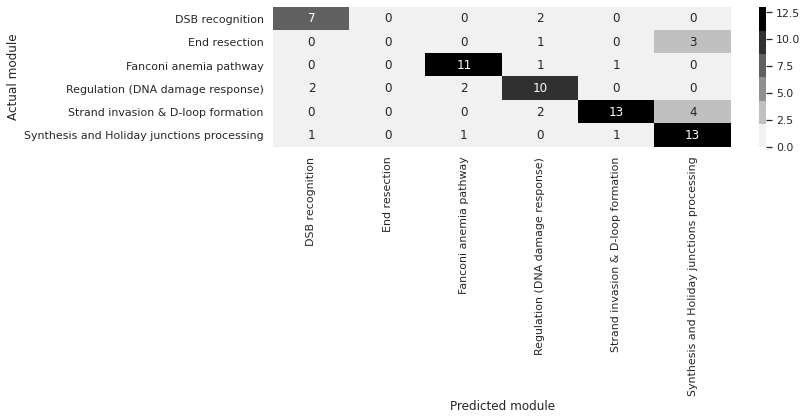

In [9]:
X = raw_data.copy()
#train xgboost model 
name = "XGBoost"
train_data = X.loc[gs_genes,:]
labels = [gold_module[x] for x in train_data.index.values]
train_data.to_csv(my_dir + "train_data.csv")

svmodel = ModuleClassifier(train_data, labels, OneVsRestClassifier(XGBClassifier()), scaler = MinMaxScaler())
print("testing model " + name)
svmodel.leave_one_out()
svmodel.plot_confusion_matrix()
gs_predictions= pd.DataFrame({"Gene": gs_genes, "module": svmodel.y_expected,
                              name+"_predicted_module": svmodel.y_predicted})
gs_predictions.to_csv("XGBoost_module_predictions_for_gs_genes.csv")

print ("training final model " + name)
svmodel.train_model()

res = pd.DataFrame({"Gene": new_genes, name+"_prediction": svmodel.predict(X.loc[new_genes,:]),
                   name+"_probs":list(svmodel.predict_proba(X.loc[new_genes,:]))})

In [10]:
colors = {'DSB recognition': "#4C72B0",
 'End resection': "#DD8452",
 'Fanconi anemia pathway': "#C44E52",
 'New': "#8C8C8C",
 'Regulation (DNA damage response)': "#55A868",
 'Strand invasion & D-loop formation': "#8172B3",
 'Synthesis and Holiday junctions processing': "#937860"}

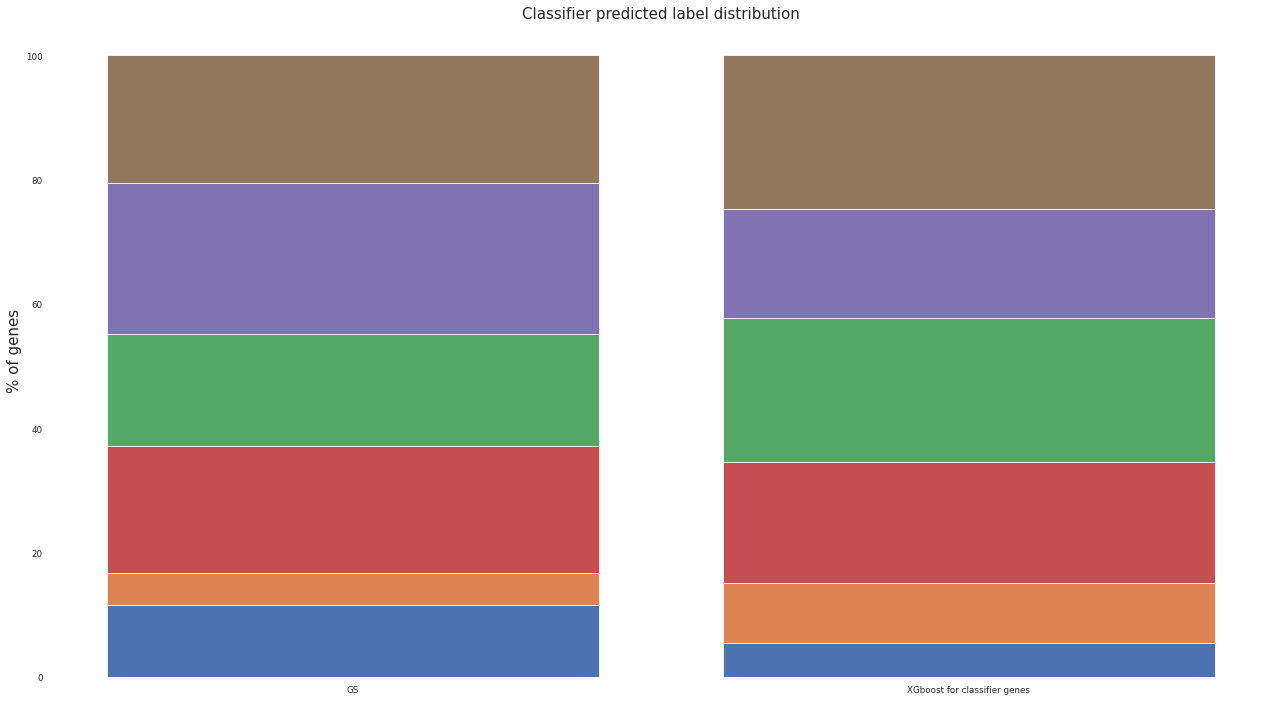

In [11]:
#plot prediction distributions
module_predictions = res.copy()

#module percent plot
gs_counts = pd.DataFrame(gold_standard.groupby("Functional module")["Gene"].count())
inclusive_counts = pd.DataFrame(module_predictions.groupby(name+"_prediction")["Gene"].count())
all_counts = pd.concat([gs_counts, inclusive_counts], axis = 1, sort = True)
all_counts.columns = ["GS", "XGboost for classifier genes"]
all_counts /= np.sum(all_counts, axis = 0)
all_counts *= 100

all_counts.to_csv(out_dir + "predicted_distribution_for_classifier_genes.csv")
#plot percentages
sns.set_context("paper", rc={"font.size":15,"axes.titlesize":15,"axes.labelsize":15, "axes.ticksize": 15})

barWidth = 0.5
r = range(all_counts.shape[1]) #locations
fig,ax = plt.subplots(figsize = (18, 10))
handles = []
for i in range(len(all_counts)):
    row = list(all_counts.iloc[i].values)
    bottom = None
    if i:
        bottom = list(all_counts.iloc[:i].sum())
    bar = plt.bar(r, row, color=colors[all_counts.index.values[i]], bottom=bottom, edgecolor='white')
    handles.append(bar[0])
ax.set_xticks(r)
ax.set_xticklabels(all_counts.columns)
ax.set_ylabel("% of genes")
ax.set_title("Classifier predicted label distribution")
ax.set_facecolor('white')
plt.tight_layout()
plt.savefig(out_dir + "predicted_distribution_for_classifier_genes.pdf")

plt.show()



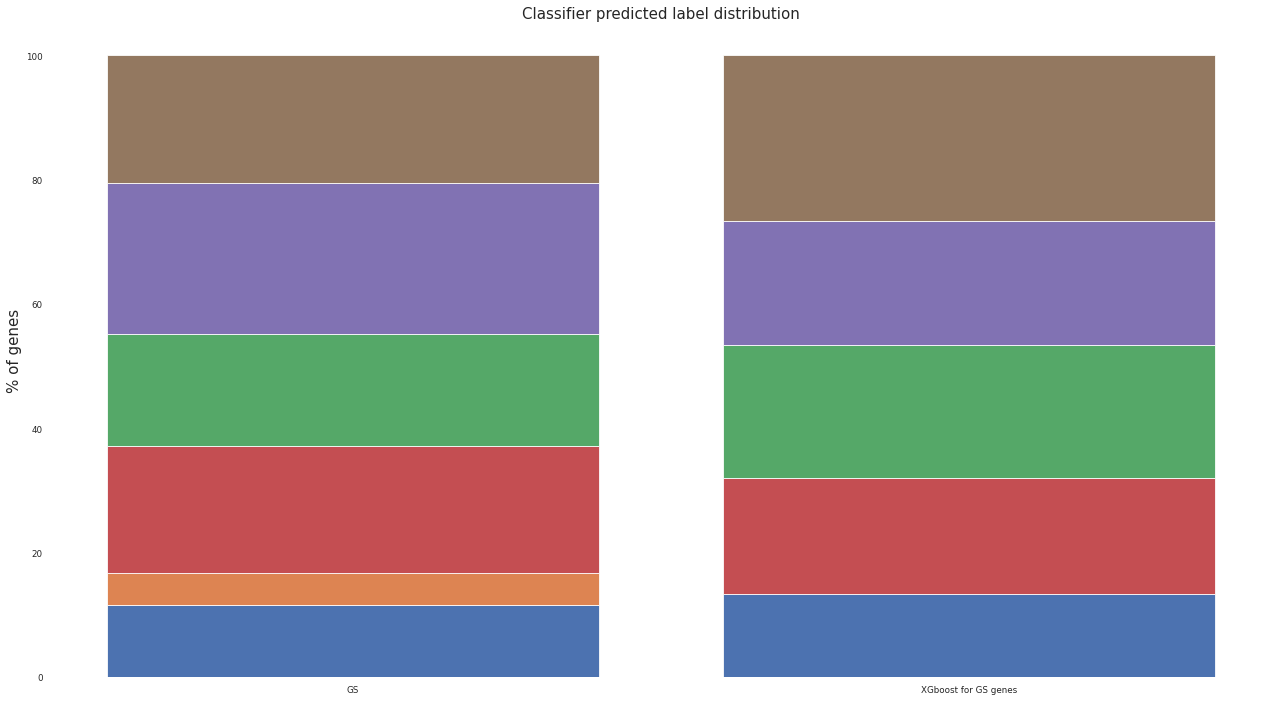

In [12]:
#plot prediction distributions
module_predictions_for_gs_genes = gs_predictions.copy()

#module percent plot
gs_counts = pd.DataFrame(gold_standard.groupby("Functional module")["Gene"].count())
inclusive_counts = pd.DataFrame(module_predictions_for_gs_genes.groupby(name+"_predicted_module")["Gene"].count())
all_counts = pd.concat([gs_counts, inclusive_counts], axis = 1, sort = True)
all_counts.columns = ["GS", "XGboost for GS genes"]
all_counts /= np.sum(all_counts, axis = 0)
all_counts *= 100

all_counts.to_csv(out_dir + "predicted_distribution_for_GS_genes.csv")
#plot percentages
sns.set_context("paper", rc={"font.size":15,"axes.titlesize":15,"axes.labelsize":15, "axes.ticksize": 15})

barWidth = 0.5
r = range(all_counts.shape[1]) #locations
fig,ax = plt.subplots(figsize = (18, 10))
handles = []
for i in range(len(all_counts)):
    row = list(all_counts.iloc[i].values)
    bottom = None
    if i:
        bottom = list(all_counts.iloc[:i].sum())
    bar = plt.bar(r, row, color=colors[all_counts.index.values[i]], bottom=bottom, edgecolor='white')
    handles.append(bar[0])
ax.set_xticks(r)
ax.set_xticklabels(all_counts.columns)
ax.set_ylabel("% of genes")
ax.set_title("Classifier predicted label distribution")
ax.set_facecolor('white')
plt.tight_layout()
plt.savefig(out_dir + "predicted_distribution_for_GS_genes.pdf")

plt.show()



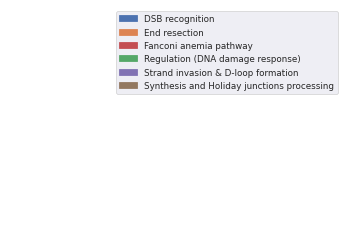

In [13]:
#legend seperately
module_colors = {'DSB recognition': "#4C72B0",
 'End resection': "#DD8452",
 'Fanconi anemia pathway': "#C44E52",
 'Regulation (DNA damage response)': "#55A868",
 'Strand invasion & D-loop formation': "#8172B3",
 'Synthesis and Holiday junctions processing': "#937860"}

handles = []
for module, color in module_colors.items():
    handles.append(mpatches.Patch(color=color, label=module))
plt.legend(handles=handles)

ax.patch.set_facecolor('white')
plt.axis('off')
plt.savefig(out_dir + "legend.pdf")

plt.show()
res.to_csv(my_dir + "res.csv")

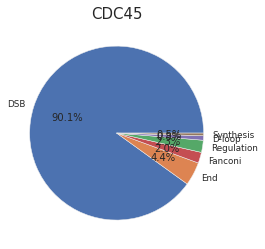

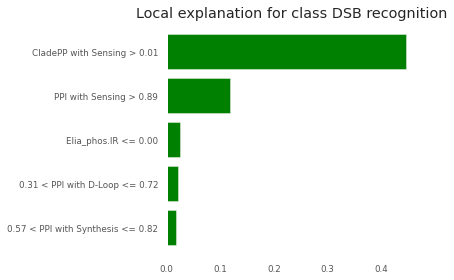

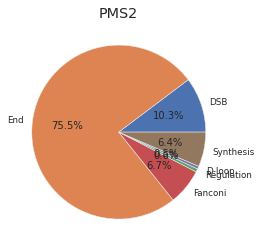

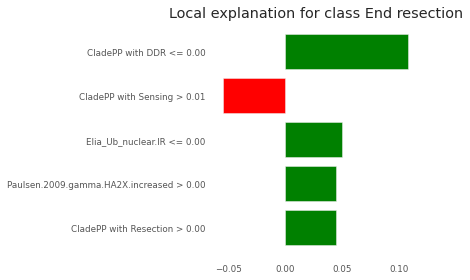

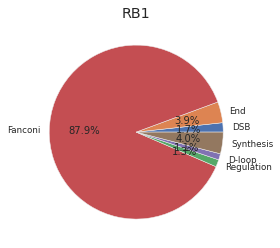

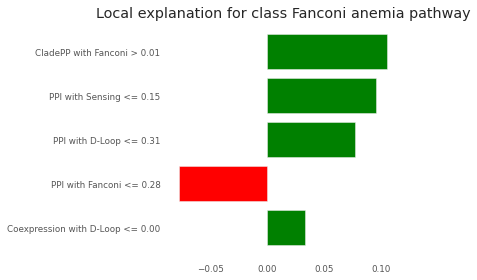

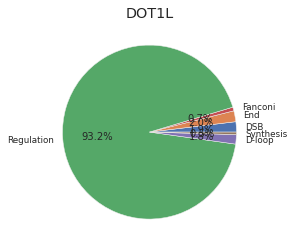

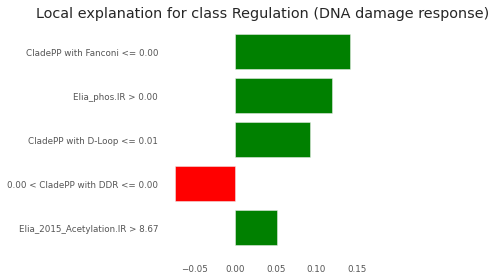

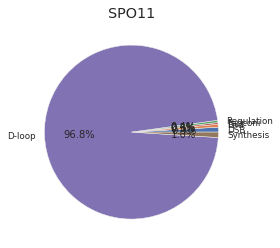

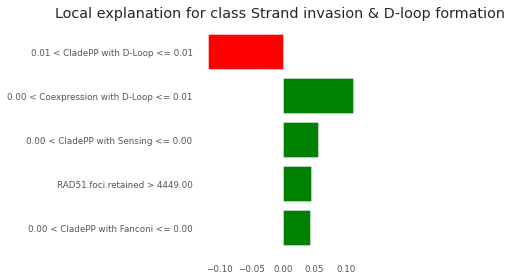

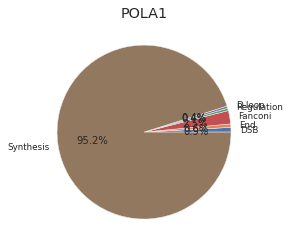

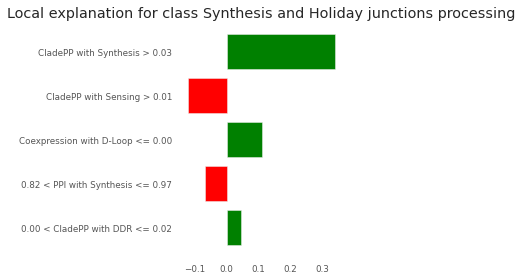

In [14]:
#plot most confident predictions and local explanations

#init lime explainer for local explanation
explainer = lime.lime_tabular.LimeTabularExplainer(train_data.values, mode='classification',training_labels=labels,feature_names=X.columns.values, class_names = svmodel.classes)

module_predictions = res.copy()
module_predictions["max"] = module_predictions["XGBoost_probs"].apply(np.max)
module_predictions.sort_values(by = "max", ascending = False, inplace = True)
# module_predictions.set_index("Gene", inplace=True)

plt.rcParams.update({'font.size': 10})

modules = ['DSB', 'End', 'Fanconi','Regulation' ,'D-loop', 'Synthesis']
color_list = [ "#4C72B0", "#DD8452", "#C44E52", "#55A868", "#8172B3", "#937860"]

# print(gold_standard.groupby("Functional module").groups)
most_confident_df = pd.DataFrame(columns = modules)

for group_name in gold_standard.groupby("Functional module").groups:
    gene = module_predictions[module_predictions["XGBoost_prediction"] == group_name].iloc[0]["Gene"] 
    predictions =  module_predictions[module_predictions["XGBoost_prediction"] == group_name].iloc[0]["XGBoost_probs"]
    
    #print(gene)
    #print([predictions])
    #print(modules)
    curr_gene_df = pd.DataFrame([predictions], columns=list(modules), index=[gene])
    # print(curr_gene_df)
    most_confident_df = most_confident_df.append(curr_gene_df)

    
    ordered = np.argsort(-predictions)
    plt.title(gene)
    plt.style.use('ggplot')
    plt.rcParams['axes.facecolor'] = 'white'

    plt.pie(predictions, colors = color_list, labels = modules, autopct='%1.1f%%')
    #plt.savefig(out_dir+"most_confident_%s_all_genes_prediction.pdf"%group_name)
    plt.savefig(out_dir+"most_confident_%s_classifier_genes_prediction.pdf"%group_name)

    # print(X.loc[gene, :])
    np.random.seed(16) # added by Idit 11/1/2022
    exp = explainer.explain_instance(X.loc[gene, :], svmodel.predict_proba, num_features=5,
                                labels = [ordered[0]])
    fig = exp.as_pyplot_figure(label = ordered[0])
    plt.grid(b=None)
    plt.tight_layout()
#    fig.savefig(out_dir + "LIME_%s_all_genes_prediction.pdf" %group_name)
    fig.savefig(out_dir + "LIME_%s_classifier_genes_prediction.pdf" %group_name)

    plt.show()
    
most_confident_df.to_csv(out_dir + "most_confident_classifier_genes_predictions.csv")


In [15]:
normal_cmap = plt.get_cmap("tab10")
custom_map = ListedColormap(
    ((0.5803921568627451, 0.403921568627451, 0.7411764705882353), #purple
    (0.5490196078431373, 0.33725490196078434, 0.29411764705882354), #brown
    (0.17254901960784313, 0.6274509803921569, 0.17254901960784313), #green
    (0.8392156862745098, 0.15294117647058825, 0.1568627450980392), #red
    (0.12156862745098039, 0.4666666666666667, 0.7058823529411765), #blue
    (1.0, 0.4980392156862745, 0.054901960784313725)))#orange



In [ ]:
classifier_genes_data = X.loc[new_genes,:]
# print(classifier_genes_data.shape)
#classifier_genes_data.to_csv(my_dir + "classifier_genes_data.csv")

new_genes_explainer = shap.KernelExplainer(svmodel.predict_proba, classifier_genes_data)
new_genes_shap_values_SVM_train = new_genes_explainer.shap_values(classifier_genes_data)

Using 385 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


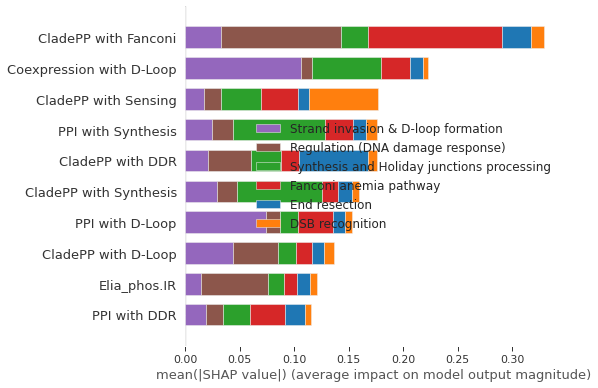

In [39]:

fig, ax = plt.subplots(figsize = (12, 50))
plt.tight_layout()
shap.summary_plot(new_genes_shap_values_SVM_train, train_data, plot_type="bar", class_names = svmodel.classes, color = custom_map,
                 max_display = 10, show = False)
fig = plt.gcf()
plt.legend().remove()
plt.tight_layout()
fig.savefig(out_dir+"SHAP_values_classifier_genes.pdf")

classifier_genes_data.to_csv(my_dir + "classifier_genes_data.csv")

import csv
from datetime import datetime
now = datetime.now() # current date and time
currdate = now.strftime("%d%m%Y")

with open(out_dir+"SHAP_values_classifier_genes_" + currdate + ".csv", 'w') as f:
    csvwriter = csv.writer(f)
    csvwriter.writerows(new_genes_shap_values_SVM_train)
train_data.to_csv(out_dir+"SHAP_train_data_" + currdate + ".csv")

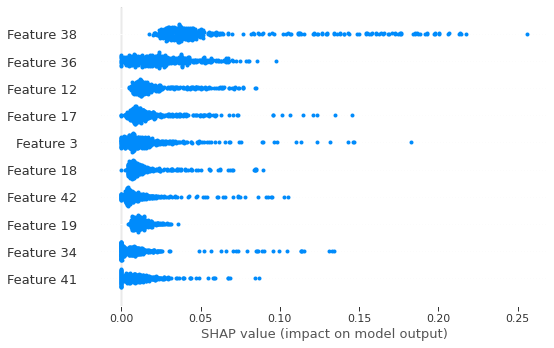

In [41]:
np.savetxt(my_dir + "new_genes_shap_values_SVM_train_1.csv", new_genes_shap_values_SVM_train[0], delimiter=",")
np.savetxt(my_dir + "new_genes_shap_values_SVM_train_2.csv", new_genes_shap_values_SVM_train[1], delimiter=",")
np.savetxt(my_dir + "new_genes_shap_values_SVM_train_3.csv", new_genes_shap_values_SVM_train[2], delimiter=",")
np.savetxt(my_dir + "new_genes_shap_values_SVM_train_4.csv", new_genes_shap_values_SVM_train[3], delimiter=",")
np.savetxt(my_dir + "new_genes_shap_values_SVM_train_5.csv", new_genes_shap_values_SVM_train[4], delimiter=",")
np.savetxt(my_dir + "new_genes_shap_values_SVM_train_6.csv", new_genes_shap_values_SVM_train[5], delimiter=",")

#shap.summary_plot(shap_values = abs(new_genes_shap_values_SVM_train[1]),  max_display = 10)



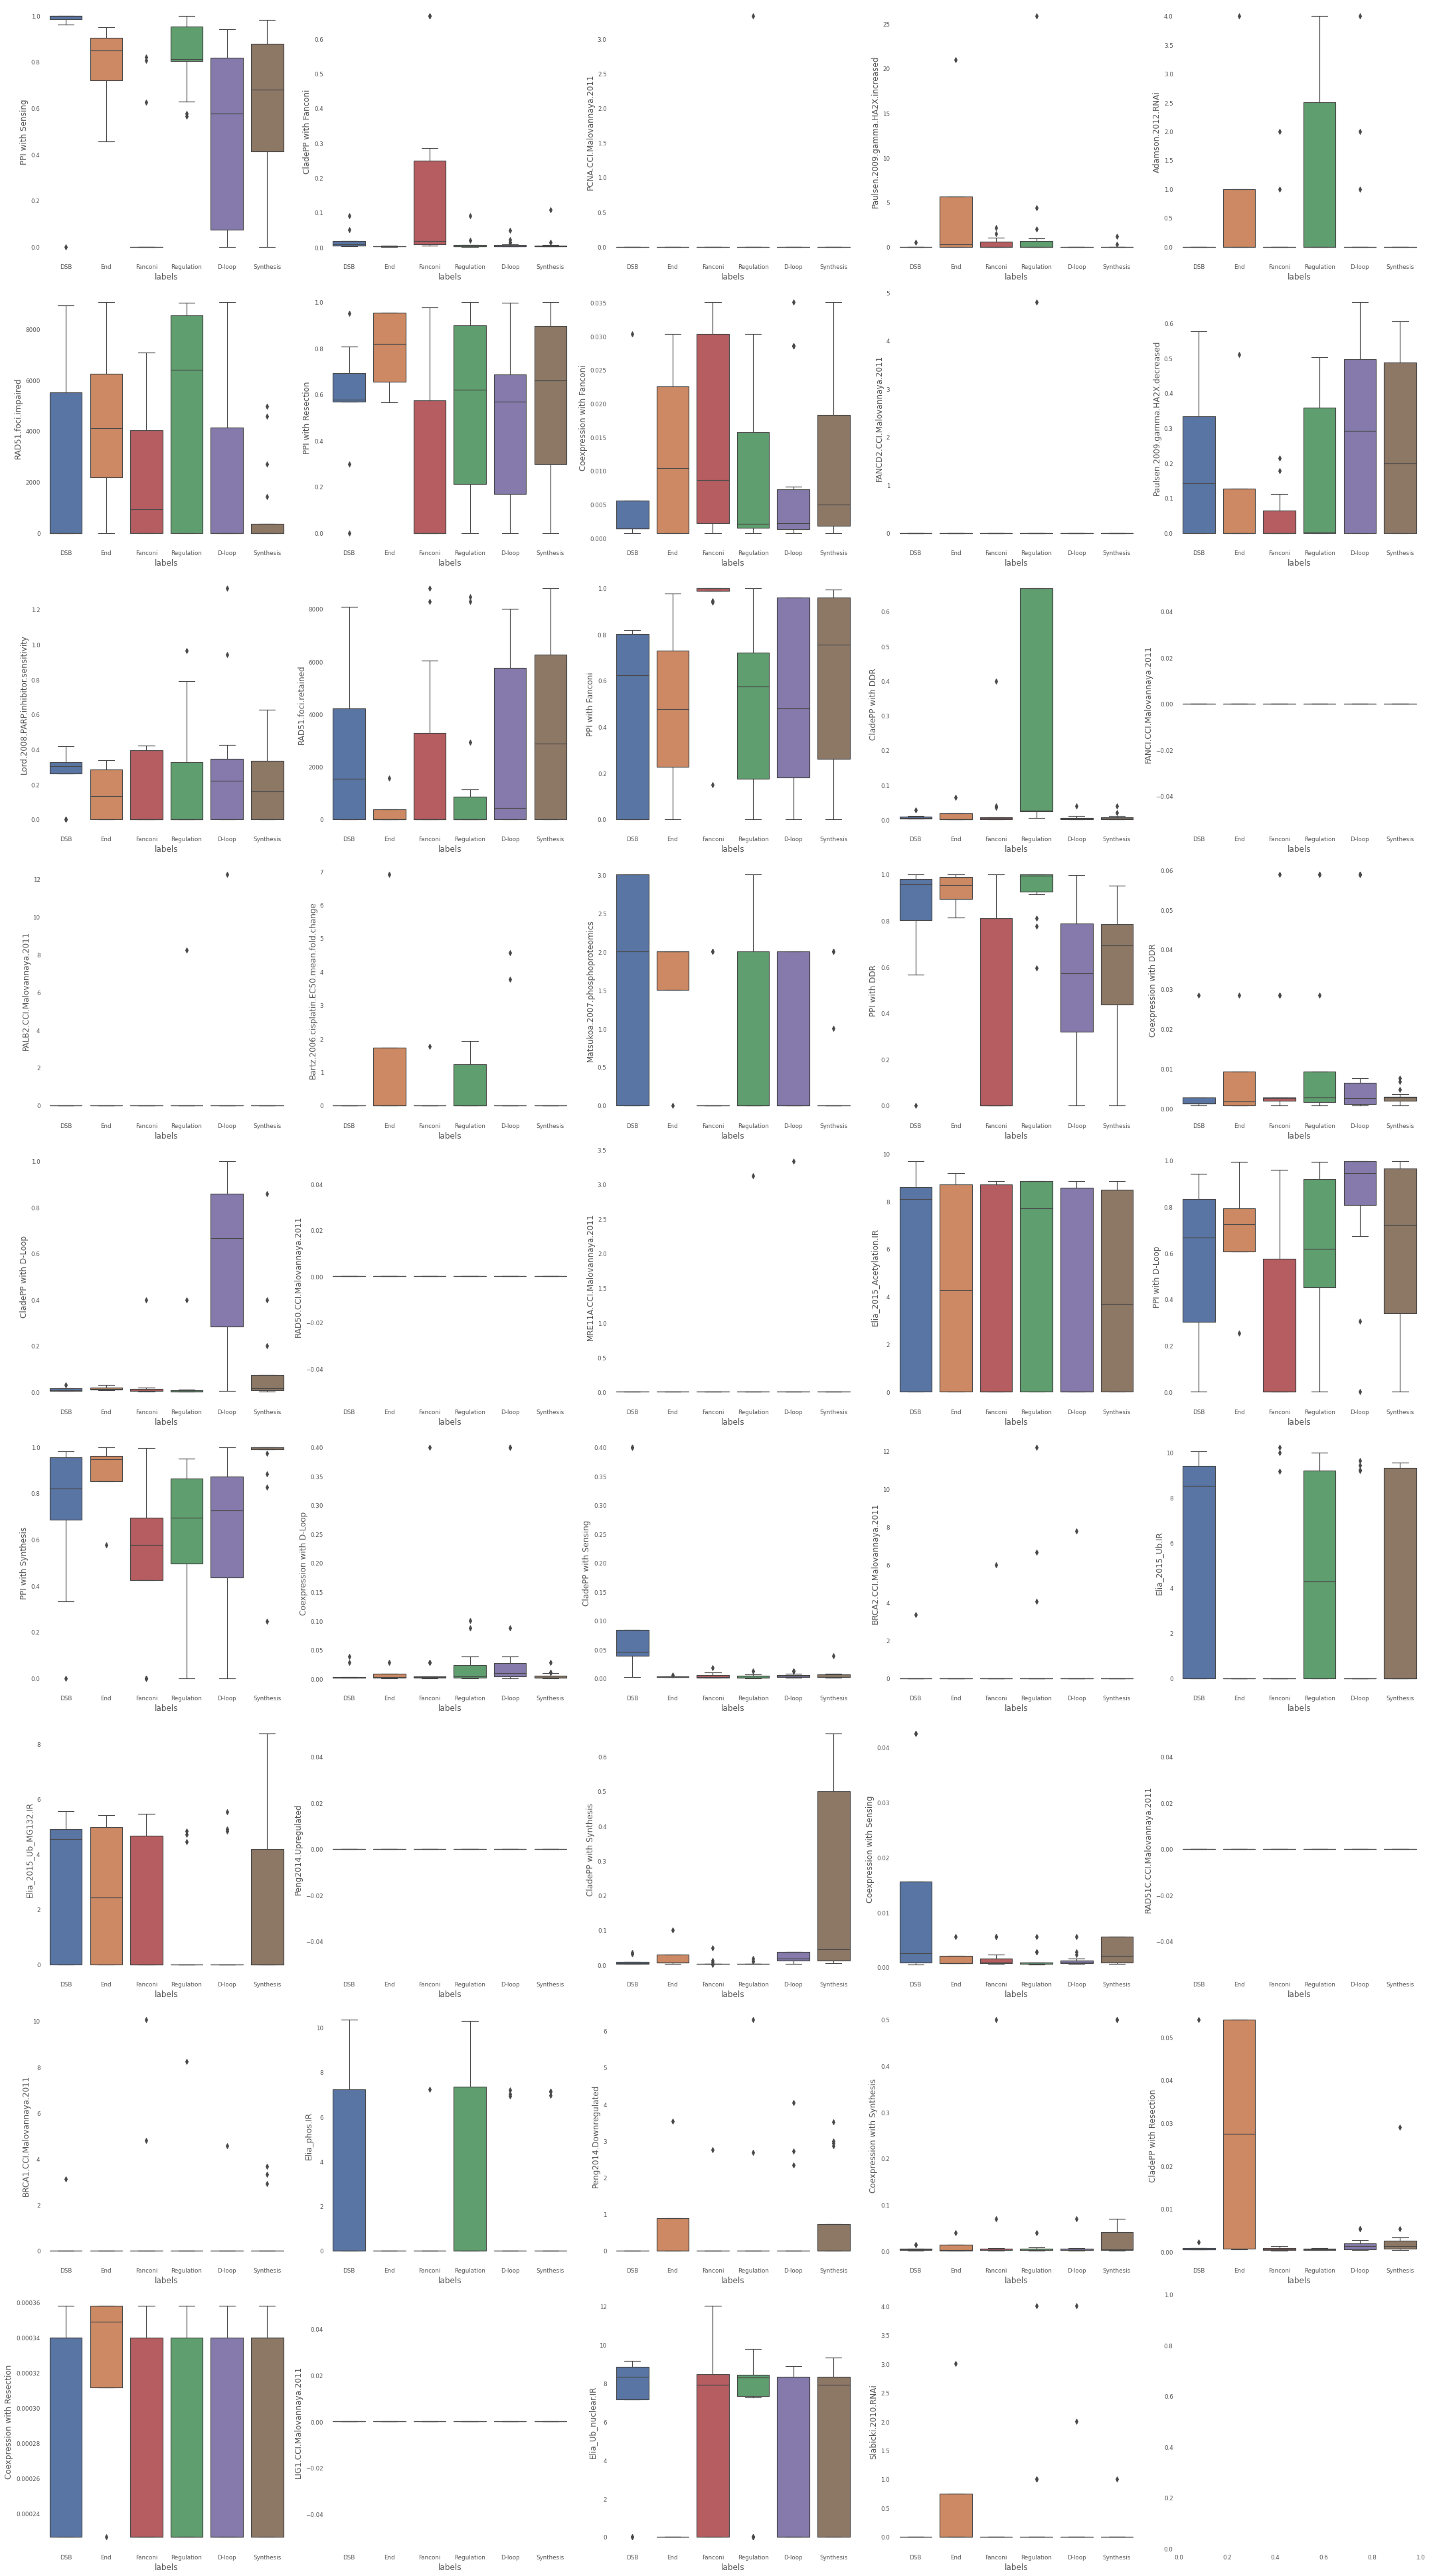

In [42]:
train_data["labels"] = labels
fig, axes = plt.subplots(9, 5, figsize = (30, 54))
for i, feature in enumerate(train_data.columns[:-1]):
    g = sns.boxplot(x="labels", y=feature, data = train_data, palette = colors, ax = axes[i%9, i%5])
    g.set(xticklabels=modules)
plt.tight_layout()

plt.show()


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open

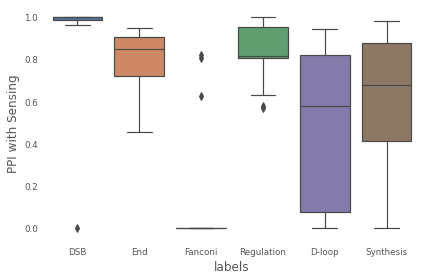

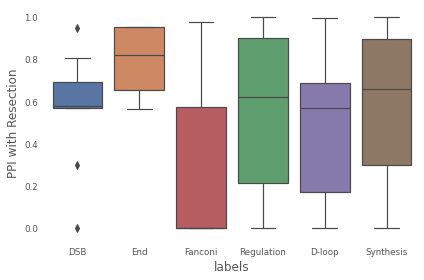

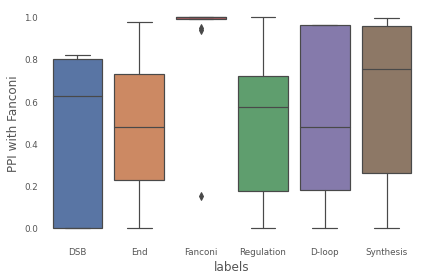

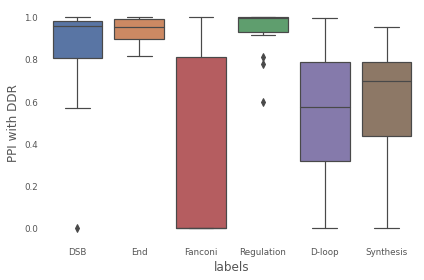

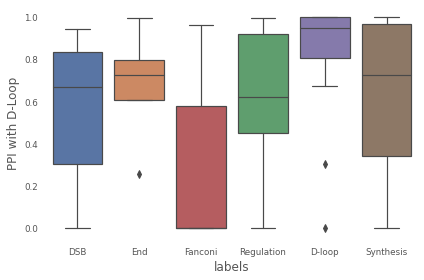

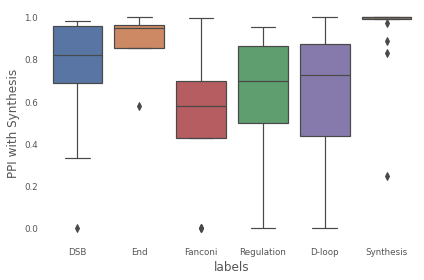

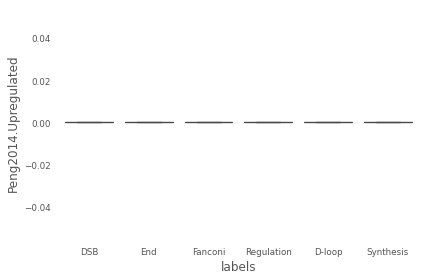

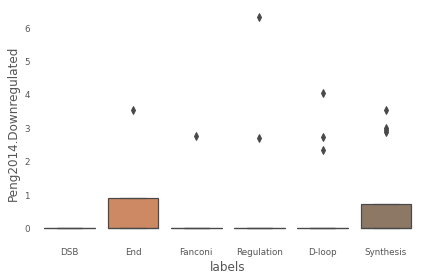

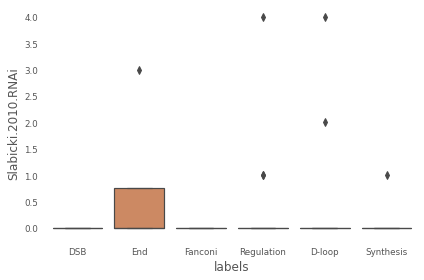

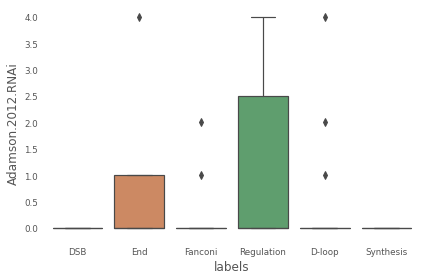

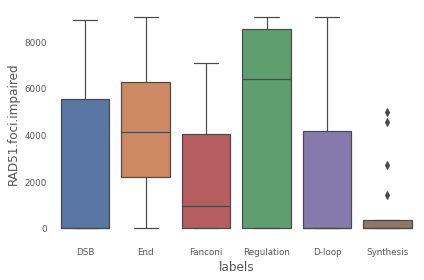

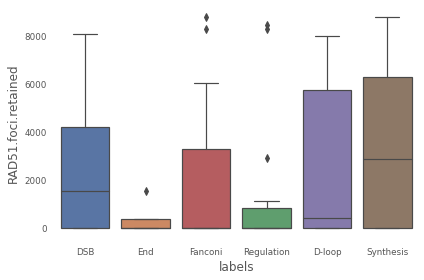

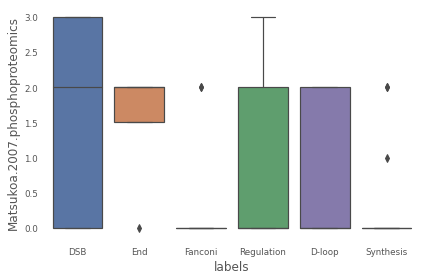

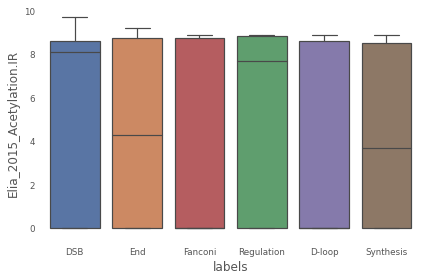

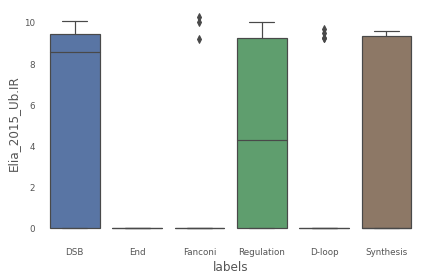

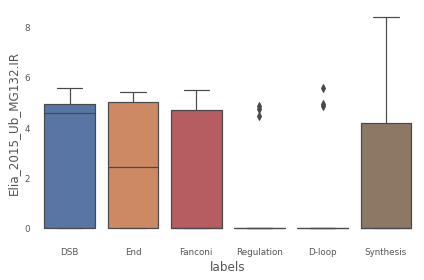

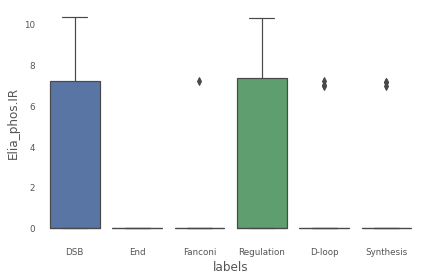

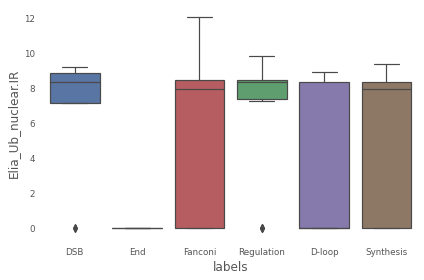

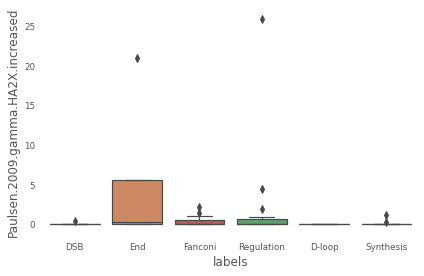

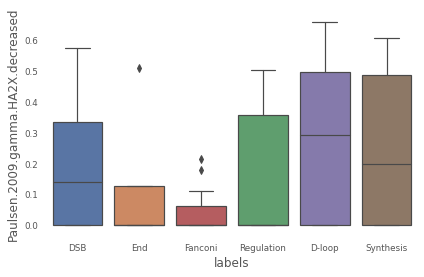

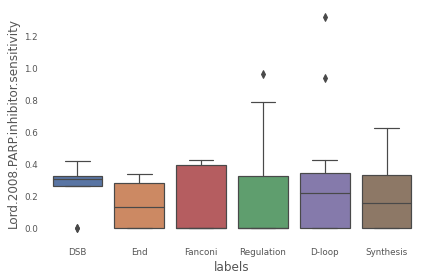

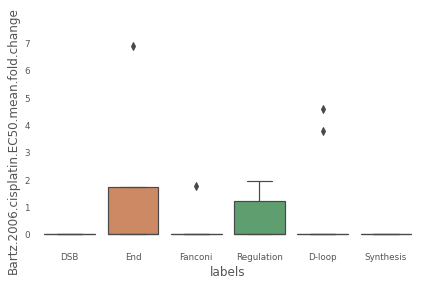

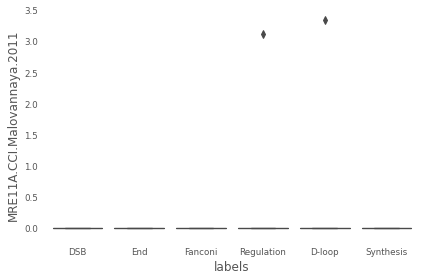

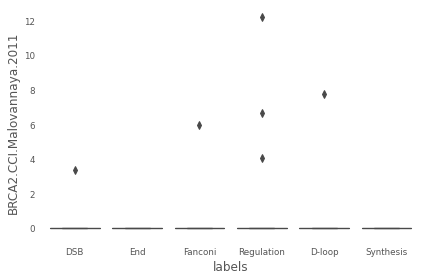

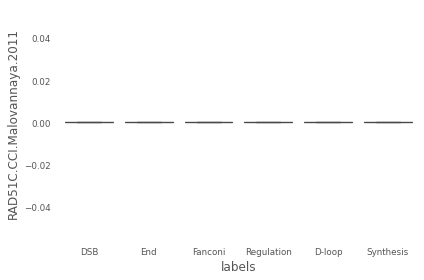

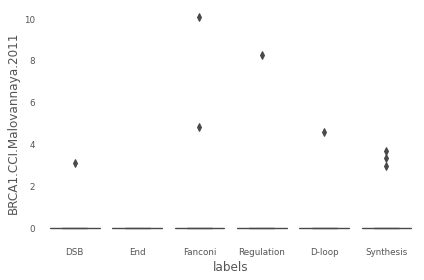

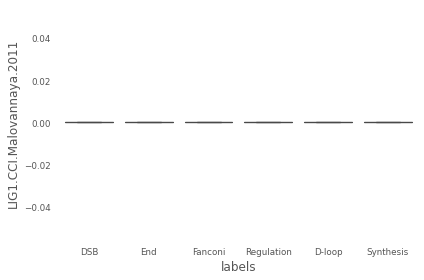

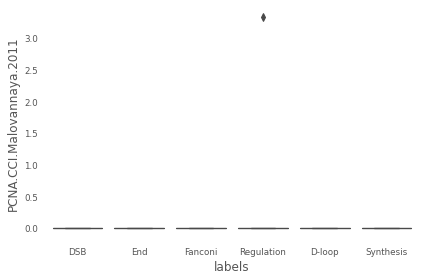

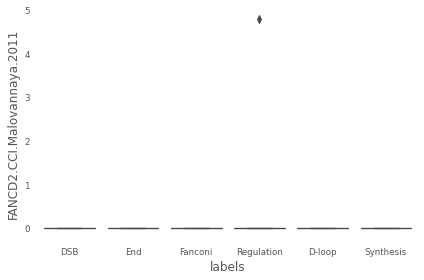

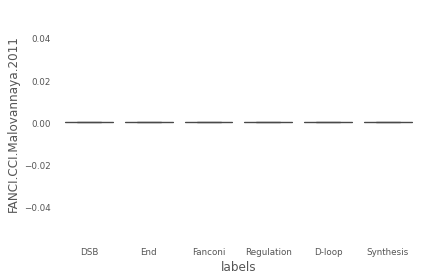

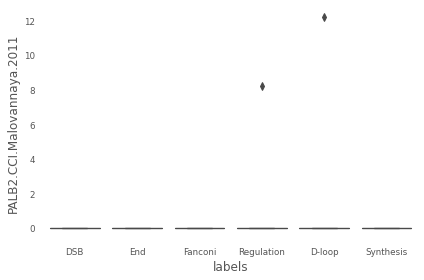

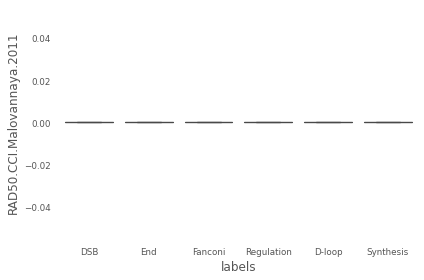

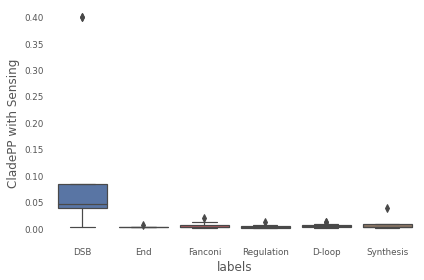

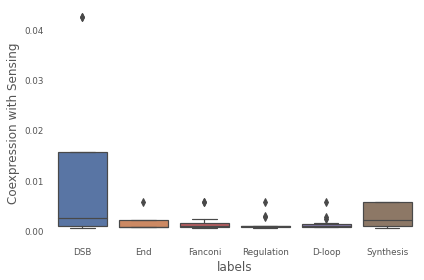

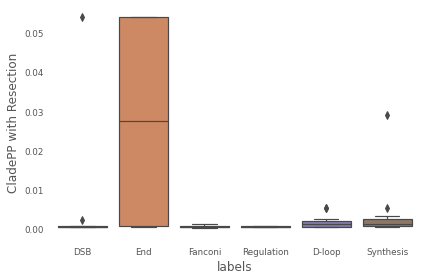

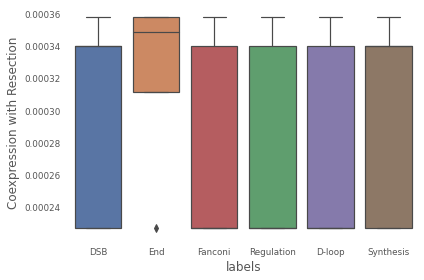

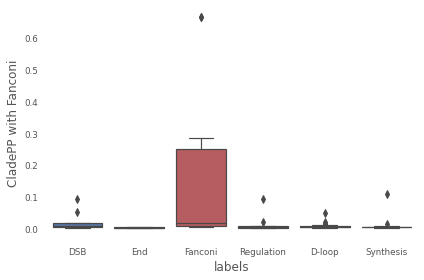

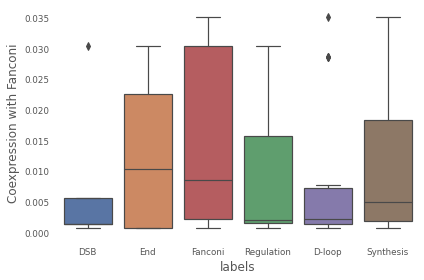

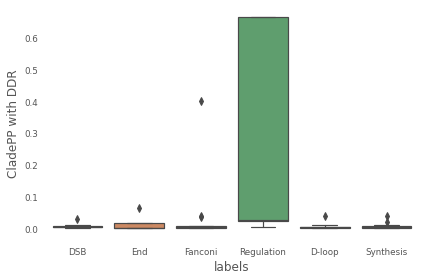

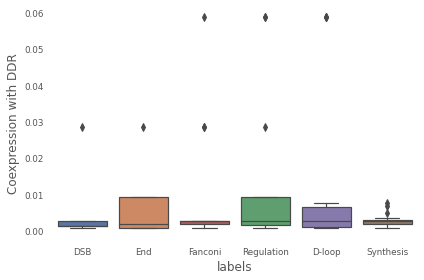

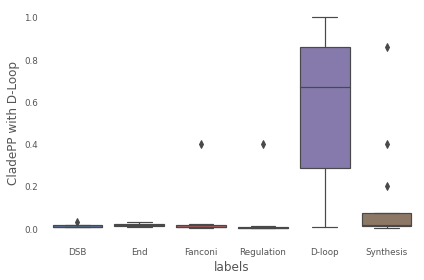

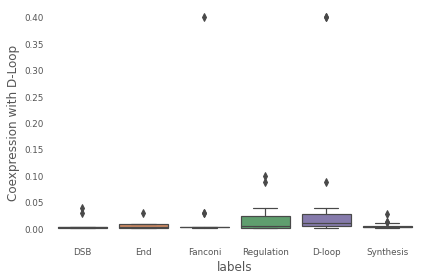

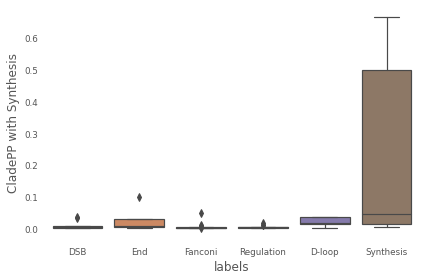

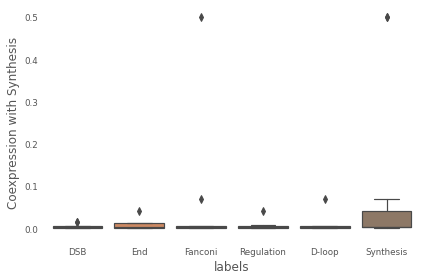

In [43]:
train_data["labels"] = labels
for i, feature in enumerate(train_data.columns[:-1]):
    fig, ax = plt.subplots()
    g = sns.boxplot(x="labels", y=feature, data = train_data, palette = colors)
    g.set(xticklabels=modules)
    plt.tight_layout()
    plt.savefig(out_dir+"single_features/%s.pdf" %feature)



In [44]:
# module_predictions.to_csv(my_dir + "xgboost_predictions_all_genes_" + currdate + ".csv")
module_predictions.to_csv(my_dir + "xgboost_predictions_classifier_genes_" + currdate + ".csv")